# Lab 9

### <span style="color:chocolate"> Submission requirements </span>

Your homework will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

In this lab, we'll train models for sentiment classification and experiment with learned embeddings for text features.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

/tmp/ipykernel_343105/965524898.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-17 19:49:40.446980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 19:49:40.447009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 19:49:40.447971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

## Data for Sentiment Classification

In this lab, we'll train a *sentiment* classifier for movie reviews. That is, the input is the text of a movie review and the output is the probability the input was a positive review. The target labels are binary, 0 for negative and 1 for positive.

Our data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words) and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [2]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)
First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65

So our first training example is a positive review. But that sequence of integer IDs is hard to read. The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [3]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

Largest ID: 88587


Note that our index (and reverse index) have over 88,000 tokens. That's quite a large vocabulary! Let's also write a decoding function for our data.

In [4]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

### Text Lengths
As usual, let's start with some data analysis. How long are the reviews? Is there a difference in length between positive and negative reviews? A histogram will help answer these questions.

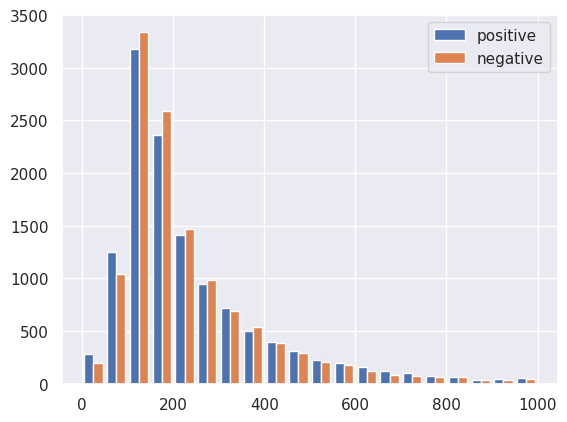

Longest positive review: 2494
Longest negative review: 1571


In [5]:
# Create a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 1000),
         label=['positive', 'negative'])
plt.legend()
plt.show()

# Also check the longest reviews.
print('Longest positive review:', max(text_lengths_pos))
print('Longest negative review:', max(text_lengths_neg))

---
### Exercise 1: Token Counts (20 points)
For each of the given tokens, construct a table with the number of positive training examples that include that token and the number of negative training examples that include that token. For reference, here are the counts for the first two tokens:

|Token|Pos Count|Neg Count|
|-|-|-|
|good|4767|4849|
|bad|1491|4396|

In [6]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']
# YOUR CODE HERE
XY_train = pd.DataFrame({"X": X_train, "Token": Y_train})
XY_train["X"] = XY_train["X"].apply(lambda list: [reverse_index[item] for item in list])
XY_train["Token"] = XY_train["Token"].map({1:"Pos Count", 0: "Neg Count"})
table = pd.DataFrame(columns=["Token", "Pos Count", "Neg Count"])
for token in tokens:
    mask = XY_train['X'].apply(lambda x: token in x) 
    counts = XY_train.loc[mask, 'Token'].value_counts()   
    row = pd.DataFrame([{
        "Token": token,
        "Pos Count": counts.get("Pos Count", 0),
        "Neg Count": counts.get("Neg Count", 0)
    }])
    table = pd.concat([table,row], ignore_index=True)

table

,Token,Pos Count,Neg Count
0,good,4767,4849
1,bad,1491,4396
2,amazing,868,240
3,boring,301,1205
4,laugh,525,685
5,cry,231,114


---

## Feature Representation
Consider the difference between the pixel features we used for image classification and the text features we are now dealing with.

An image had 784 pixel positions. At each position, there is a single value in [0,1] (after normalization).

In contrast, a review has a variable number of ordered tokens (up to 2494 in the training examples). Each token occurs in a particular position. We can think of the token positions much like the 784 pixel positions, except that some of the trailing positions are empty, since review lengths vary.  At each token position, there is a single token, one of the 88587 entries in the vocabulary. So we can think of a review as a (2500, 90000) matrix: At each of ~2500 token positions, we have 1 of ~90000 token ids.

This representation would have 2500 * 90000 = 225 million features -- quite a lot more complexity than the images, though as you'll see below, we will make some simplifying assumptions, reducing both the number of token positions and the number of vocabulary items.

### Padding and Reduced Length
As is clear from the length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, let's add special padding tokens at the end of each review until they are all the same length.

We'll also use this operation to limit the number of token positions by truncating all reviews to a specified length. In the code below, as an example, we pad all training inputs to length 300.

In [7]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

# Pad and truncate to 300 tokens.
X_train_padded = pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

### Reduced Vocabulary
We also want to be able to limit the vocabulary size. Since our padding function produces fixed-length sequences in a numpy matrix, we can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

In the code below, as an example, we'll keep just token ids less than 1000, replacing all others with OOV.

In [8]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### One-hot Encoding
Our current feature representations are **sparse**. That is, we only keep track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

As discussed above, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary). We'll clip each review after 20 tokens (so 2500 -> 20) and keep only the most common 1000 tokens (so 90000 -> 1000).

In [9]:
# Keras has a util to create one-hot encodings.
X_train_padded = pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of our 25000 training examples, we have a 20 x 1000 matrix. That is, for each of 20 token positions, we have a vector of 1000 elements containing a single 1 and 999 zeros.

We can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. We'll get to that soon.

## Logistic Regression with One-Hot Encodings
Let's start with something familiar -- logistic regression. Since our feature representation is in 2 dimensions (20 x 1000), we need to flatten it to pass it to Keras (remember we did this with the pixel data too). Let's try two strategies for flattening.

1. Flatten by *concatenating* (as we did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position.
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

NOTE: Our prior assignments have used the standard Stochastic Gradient Descent (SGD) optimizer to compute the gradient from an estimate of the loss (based on the current mini-batch). There are many alternative optimizers. Here we'll use the **Adam** optimizer, which sometimes gives better results. One key characteristic of Adam is that it effectively uses a different learning rate for each parameter rather than a fixed learning rate as in SGD.

In [10]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to our training data and check performance metrics on the validation (held-out) data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [11]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

2024-03-17 19:49:45.451608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 19:49:45.481376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 19:49:45.481600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/5


2024-03-17 19:49:48.657887: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 20/352 [>.............................] - ETA: 0s - loss: 0.6938 - accuracy: 0.4945  

2024-03-17 19:49:48.959809: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c8a6046fe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-17 19:49:48.959827: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-17 19:49:48.963791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-17 19:49:48.978887: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710719389.040304  343300 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 [==============================] - 2s 4ms/step - loss: 0.6791 - accuracy: 0.6100 - val_loss: 0.6658 - val_accuracy: 0.6568
Epoch 2/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6338 - accuracy: 0.7411 - val_loss: 0.6453 - val_accuracy: 0.6764
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5971 - accuracy: 0.7744 - val_loss: 0.6292 - val_accuracy: 0.6788
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5669 - accuracy: 0.7976 - val_loss: 0.6180 - val_accuracy: 0.6884
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5413 - accuracy: 0.8100 - val_loss: 0.6089 - val_accuracy: 0.6892


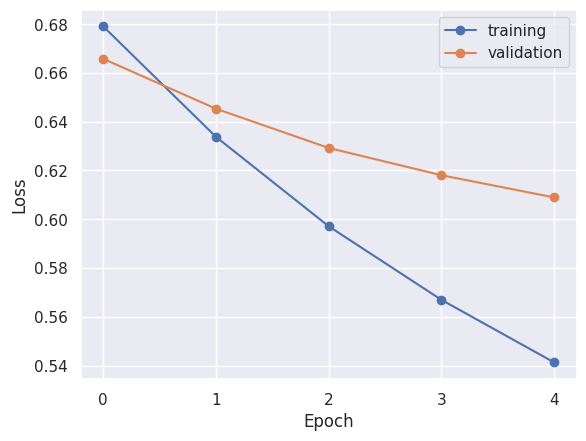

In [12]:
model = build_onehot_model()

# Fit the model.
history = model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history)


---
### Exercise 2: Comparing logistic regrerssion models (20 points)
Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results? 

In [13]:
print("LR-C History")
print(history)
print("LR-C Summary")
print(model.summary())

model = build_onehot_model(average_over_positions=True)

# Fit the model.
history = model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=0             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
print("LR-A History")
print(history)
print("LR-A Summary")
print(model.summary())

LR-C History
       loss  accuracy  val_loss  val_accuracy
0  0.679064  0.610000  0.665771        0.6568
1  0.633768  0.741067  0.645316        0.6764
2  0.597083  0.774444  0.629216        0.6788
3  0.566921  0.797600  0.618047        0.6884
4  0.541251  0.810044  0.608923        0.6892
LR-C Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 20001 (78.13 KB)
Trainable params: 20001 (78.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
LR-A History
       loss  accuracy  val_loss  val_accuracy
0  0.690590  0.609822  0.688310        0.6636
1  0

*Written answers:*

1. | Model | Training Accuracy | Validation Accuracy |
   | :-: | :-: | :-: |
   | LR-C | 0.81 | 0.69 |
   | LR-A | 0.70 | 0.69 |
2. | Model | Number of Parameters |
   | :-: | :-: |
   | LR-C | 20001 |
   | LR-A | 1001 |
3. LR-C is overfitting given that it's validation loss deviates substantially from its training loss
4. The LR-C model effectively contains more information; it includes the position of tokens, where as the LR-A model effectively compresses the token data down to the average number of times tokens are used. The fact that the LR-C model overfits while the LR-A model does not tells us that for the use case of sentiment classification, it matters more how often certain word are used than the order in which they are used. Because of this, the position information effectively creates more variance, which the neural net will overfit to given is flexibility and increased number of parameters.


---

## Logistic Regression with Embeddings
Next, let's train model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [14]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

Try training the model as before. We'll use the averaging strategy rather than the concatenating strategy for dealing with the token sequence. That is, we'll look up embedding vectors for each token. Then we'll average them to produce a single vector. Then we'll traing a logistic regression with that vector as input to predict the binary label.

Epoch 1/5


352/352 [==============================] - 6s 17ms/step - loss: 0.6903 - accuracy: 0.6193 - val_loss: 0.6854 - val_accuracy: 0.6484
Epoch 2/5
352/352 [==============================] - 2s 5ms/step - loss: 0.6746 - accuracy: 0.6838 - val_loss: 0.6646 - val_accuracy: 0.6824
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6486 - accuracy: 0.6986 - val_loss: 0.6385 - val_accuracy: 0.6976
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6209 - accuracy: 0.7112 - val_loss: 0.6149 - val_accuracy: 0.7008
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5962 - accuracy: 0.7171 - val_loss: 0.5954 - val_accuracy: 0.7100


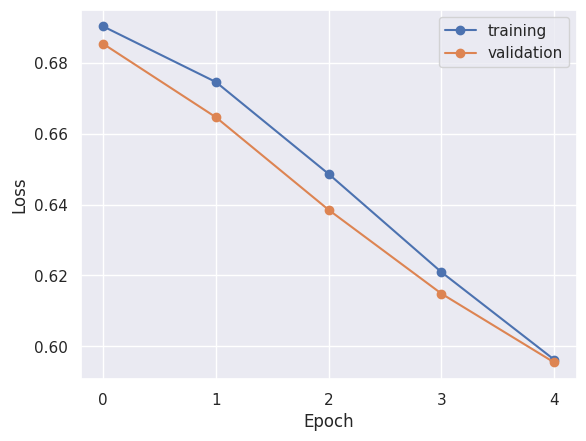

In [15]:
model = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

---
### Exercise 3: Experiments with embeddings (20 points)
Train 6 models with embedding sizes in [2,4,8,16,32,64], keeping other settings fixed. Use the averaging strategy rather than the concatenating strategy.

1. Construct a table with the training and validation accuracies of each model (after 5 training epochs).
2. Compute the number of parameters in each model.
3. Do learned embeddings appear to provide improved performance over the one-hot encoding? Why?

Epoch 1/5


352/352 [==============================] - 4s 10ms/step - loss: 0.6879 - accuracy: 0.6340 - val_loss: 0.6809 - val_accuracy: 0.6652
Epoch 2/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6686 - accuracy: 0.6906 - val_loss: 0.6585 - val_accuracy: 0.6864
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6419 - accuracy: 0.7010 - val_loss: 0.6327 - val_accuracy: 0.6980
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6149 - accuracy: 0.7134 - val_loss: 0.6102 - val_accuracy: 0.7052
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5911 - accuracy: 0.7199 - val_loss: 0.5917 - val_accuracy: 0.7120


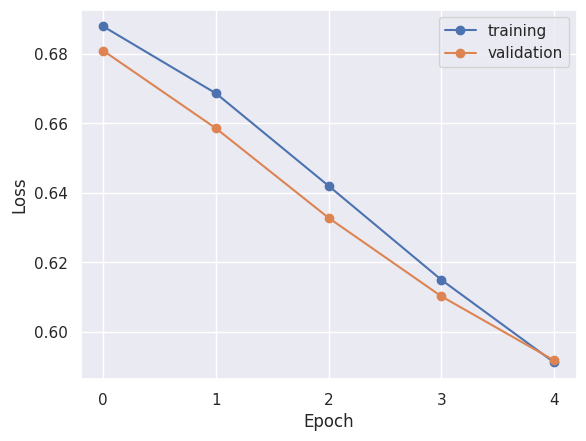

Epoch 1/5
352/352 [==============================] - 7s 18ms/step - loss: 0.6829 - accuracy: 0.6454 - val_loss: 0.6700 - val_accuracy: 0.6760
Epoch 2/5
352/352 [==============================] - 2s 5ms/step - loss: 0.6493 - accuracy: 0.7016 - val_loss: 0.6342 - val_accuracy: 0.7024
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.6105 - accuracy: 0.7126 - val_loss: 0.6016 - val_accuracy: 0.7088
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5787 - accuracy: 0.7237 - val_loss: 0.5789 - val_accuracy: 0.7140
Epoch 5/5
352/352 [==============================] - 1s 4ms/step - loss: 0.5552 - accuracy: 0.7306 - val_loss: 0.5633 - val_accuracy: 0.7180


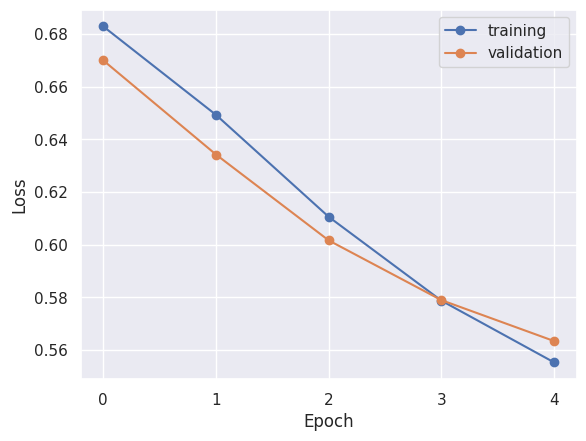

Epoch 1/5
352/352 [==============================] - 7s 17ms/step - loss: 0.6798 - accuracy: 0.6432 - val_loss: 0.6605 - val_accuracy: 0.6820
Epoch 2/5
352/352 [==============================] - 2s 4ms/step - loss: 0.6298 - accuracy: 0.7040 - val_loss: 0.6101 - val_accuracy: 0.7080
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5809 - accuracy: 0.7202 - val_loss: 0.5756 - val_accuracy: 0.7140
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5491 - accuracy: 0.7323 - val_loss: 0.5569 - val_accuracy: 0.7224
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7408 - val_loss: 0.5462 - val_accuracy: 0.7204


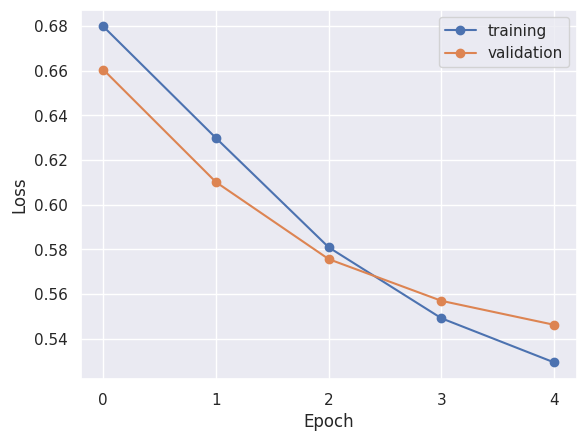

Epoch 1/5
352/352 [==============================] - 6s 17ms/step - loss: 0.6703 - accuracy: 0.6565 - val_loss: 0.6396 - val_accuracy: 0.6904
Epoch 2/5
352/352 [==============================] - 2s 4ms/step - loss: 0.5992 - accuracy: 0.7154 - val_loss: 0.5803 - val_accuracy: 0.7120
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5492 - accuracy: 0.7318 - val_loss: 0.5529 - val_accuracy: 0.7216
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5238 - accuracy: 0.7420 - val_loss: 0.5416 - val_accuracy: 0.7216
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5102 - accuracy: 0.7489 - val_loss: 0.5363 - val_accuracy: 0.7280


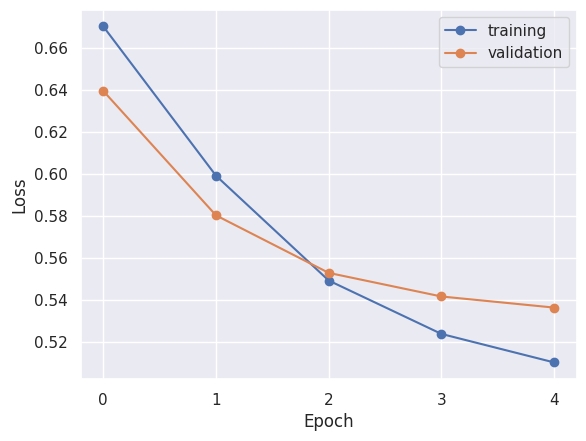

Epoch 1/5
352/352 [==============================] - 7s 18ms/step - loss: 0.6579 - accuracy: 0.6646 - val_loss: 0.6141 - val_accuracy: 0.6980
Epoch 2/5
352/352 [==============================] - 2s 5ms/step - loss: 0.5685 - accuracy: 0.7231 - val_loss: 0.5568 - val_accuracy: 0.7200
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5257 - accuracy: 0.7404 - val_loss: 0.5398 - val_accuracy: 0.7252
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5081 - accuracy: 0.7468 - val_loss: 0.5351 - val_accuracy: 0.7284
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5001 - accuracy: 0.7517 - val_loss: 0.5336 - val_accuracy: 0.7308


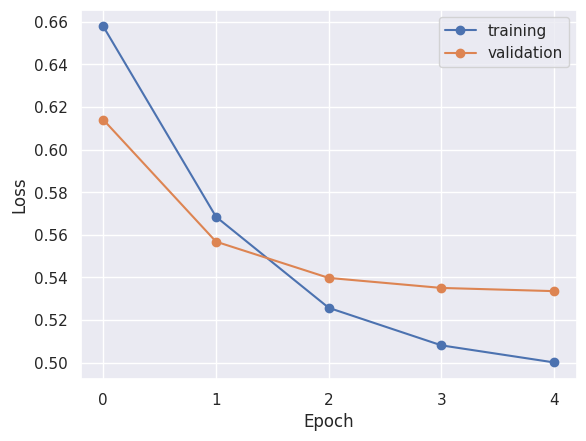

Epoch 1/5
352/352 [==============================] - 7s 18ms/step - loss: 0.6422 - accuracy: 0.6699 - val_loss: 0.5870 - val_accuracy: 0.7108
Epoch 2/5
352/352 [==============================] - 2s 5ms/step - loss: 0.5428 - accuracy: 0.7326 - val_loss: 0.5430 - val_accuracy: 0.7192
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5114 - accuracy: 0.7446 - val_loss: 0.5352 - val_accuracy: 0.7316
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5004 - accuracy: 0.7496 - val_loss: 0.5346 - val_accuracy: 0.7292
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.4962 - accuracy: 0.7553 - val_loss: 0.5348 - val_accuracy: 0.7288


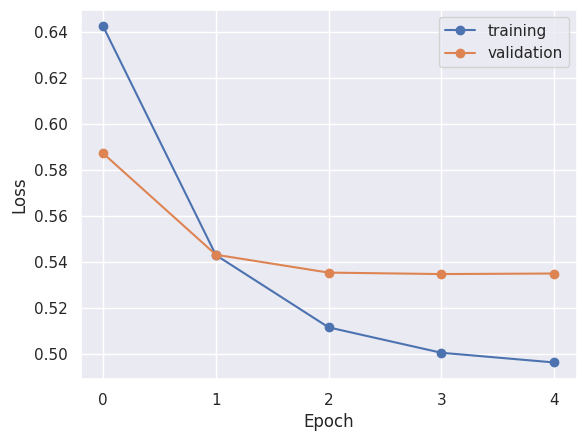

In [16]:
embeds = [2,4,8,16,32,64]
accuracies = []
params = []
for embed in embeds:
    model = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=embed)
    history = model.fit(
    x = X_train_reduced,  # our sparse padded training data
    y = Y_train,          # corresponding binary labels
    epochs=5,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1             # display some progress output during training
    )

    accuracies.append((history.history['accuracy'][-1], history.history['val_accuracy'][-1]))
    params.append(model.count_params())

    history = pd.DataFrame(history.history)
    plot_history(history)

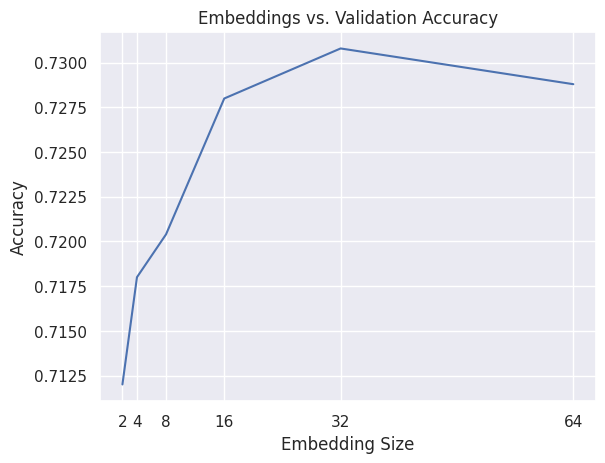

In [17]:
val_accuracies = [x[1] for x in accuracies]
plt.plot(embeds, val_accuracies)
plt.xticks(ticks=embeds, labels=[2, 4, 8, 16, 32, 64])
plt.xlabel("Embedding Size")
plt.ylabel("Accuracy")
plt.title("Embeddings vs. Validation Accuracy")
plt.show()

In [18]:
print(accuracies)
print(params)

[(0.7199110984802246, 0.7120000123977661), (0.7306222319602966, 0.7179999947547913), (0.7408444285392761, 0.7203999757766724), (0.7488889098167419, 0.7279999852180481), (0.7516888976097107, 0.7307999730110168), (0.7552888989448547, 0.7287999987602234)]
[2003, 4005, 8009, 16017, 32033, 64065]


*Written answers:*

1. | Model | Training Accuracy | Validation Accuracy |
   | :---: | :---------------: | :-----------------: |
   | 2 | 0.72 | 0.71 |
   | 4 | 0.73 | 0.72 |
   | 8 | 0.74 | 0.72 |
   | 16 | 0.75 | 0.73 |
   | 32 | 0.75 | 0.73 |
   | 64 | 0.76 | 0.73 |
2. | Model | Number of Parameters |
   | :-: | :-: |
   | 2 | 2003 |
   | 4 | 4005 |
   | 8 | 8009 |
   | 16 | 16017 |
   | 32 | 32033 |
   | 64 | 64065 |
3. Yes, learned embeddings appear to improve performance given that they increase validation accuracy. However, there is a certain point where increasing embeddings may cause overfitting and decrease performance.


---

## Inspecting Learned Embeddings
Let's retrieve the learned embedding parameters from the trained model and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. We can use the get_weights() function to get a numpy array with the parameters.

In [19]:
# Display the model layers.
display(model.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings = model.layers[0].get_weights()[0]
display(embeddings.shape)

(1000, 64)

Now we'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [20]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings, id_start=500, count=500)

---
### Exercise 4: Interpreting Embeddings (20 points)
Notice that the 2-D embeddings fall in a narrow diagonal band.

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'? What are two other surprising results?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

*Written answers:*

1. Yes, it appears that the embeddings separate positive and negative words, but not perfectly: there are many words without a strong embedding that could be used to label either positive or negative sentiments. The most negative word is "avoid". This makes sense given that the dataset contains movie reviews, and reviewers may commonly suggest that readers "avoid" a given film.
2. For the first example, the placement of tokens that reflect numbers (i.e. '7', '8', '9') seems surprising at first, but may refer to scoring out of 10, which reviewers may commonly type out in their reviews. Another suprising positive token is "today", which may be used by reviewers to suggest that viewers should go see the film today / as soon as possible.
3. The low embedding suggests that the word "crazy" is not closely associated with positivity or negativity, or with other words that are associated with positivity or negativity. This may be because "crazy" is being used by reviewers to generally describe the extent of other descriptors.
4. It is difficult to explain what learned embeddings mean discretely, beyond being useful to relatively compare the assocition of different tokens with other tokens and with classes.


---

## Scaling Up!
Remember how we limited our input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well we can do using more data and bigger models (more parameters).

### Exercise 5: Improve Results (20 points)
Using pieces of code from above, set up and train a model that improves the validation accuracy to at least 80%. You should include the following elements:

1. Truncate and pad input to the desired length.
2. Limit vocabulary to the desired size.
3. Set up a model using embeddings.
4. Add an additional layer or layers (after the embeddings layer and before the output layer).
5. Evaluate on the test data. Remember to apply the same pre-processing to the test data. You can use model.evaluate().

In [21]:
# YOUR CODE HERE
def build_better_embeddings_model(average_over_positions=False,
                           vocab_size=10000,
                           sequence_length=100,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

model = build_better_embeddings_model(average_over_positions=True)

max_token_id=10000
max_length=100

X_train_padded = pad_data(X_train, max_length=max_length)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=max_token_id)
X_test_padded = pad_data(X_test, max_length=max_length)
X_test_reduced = limit_vocab(X_test_padded, max_token_id=max_token_id)

history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
)


test_loss, test_accuracy = model.evaluate(x=X_test_reduced, y=Y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/5


352/352 [==============================] - 16s 42ms/step - loss: 0.5426 - accuracy: 0.7208 - val_loss: 0.3742 - val_accuracy: 0.8324
Epoch 2/5
352/352 [==============================] - 4s 11ms/step - loss: 0.2990 - accuracy: 0.8751 - val_loss: 0.3554 - val_accuracy: 0.8484
Epoch 3/5
352/352 [==============================] - 3s 10ms/step - loss: 0.2417 - accuracy: 0.9031 - val_loss: 0.3554 - val_accuracy: 0.8476
Epoch 4/5
352/352 [==============================] - 3s 7ms/step - loss: 0.2042 - accuracy: 0.9229 - val_loss: 0.3785 - val_accuracy: 0.8428
Epoch 5/5
782/782 [==============================] - 1s 1ms/step - loss: 0.4115 - accuracy: 0.8398
Test Loss: 0.41150346398353577
Test Accuracy: 0.8397600054740906


---